In [ ]:
random_state = 35

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import (
    Activation, BatchNormalization, Concatenate, Dense,
    Dropout, Flatten, Input, Lambda, Reshape
)
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras import backend as K
from keras import utils

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

import os
import random

seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.keras.utils.set_random_seed(seed)

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score

from tqdm import tqdm

In [ ]:
#模型输入维度
img_rows = 64
img_cols = 64
channels = 1

img_shape = (img_rows, img_cols, channels)#输入图像的维度

z_dim = 100#噪声向量的大小

num_classes = 5 #数据集中类别的数量

In [ ]:
# Set path for data source
from google.colab import drive
drive.mount('/content/gdrive')
os.chdir("/content/gdrive/My Drive/SGAN/")

Mounted at /content/gdrive


In [ ]:
from SGAN import train_model

/usr/local/lib/python3.10/dist-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [ ]:
os.chdir("/content/gdrive/My Drive/Load Diffusion/dataset/")

In [ ]:
weather = pd.read_csv('weather.csv')
metadata = pd.read_csv('metadata.csv')

In [ ]:
df_meter = []
df_meta = []

for meter_data_cleand in os.listdir():
    if meter_data_cleand.endswith('_cleaned.csv'):
        meter_type = meter_data_cleand.split('_cleaned.csv')[0]
        df_meter_data_cleand = pd.read_csv(meter_data_cleand, index_col='timestamp')

        df_meta_cleand = metadata.set_index('building_id').loc[df_meter_data_cleand.columns]
        df_meta.append(df_meta_cleand)

        df_meter_data_cleand.columns = meter_type+'_'+df_meter_data_cleand.columns
        df_meter.append(df_meter_data_cleand)

df_meter = pd.concat(df_meter, axis=1)

df_meta = pd.concat(df_meta, axis=0)
df_meta = df_meta.reset_index().rename(columns={'index':'building_id'})
df_meta.index = df_meter.columns

In [ ]:
data_availability = ~df_meter.isna()
data_availability.index = pd.to_datetime(data_availability.index)
data_availability = data_availability.resample('Y').mean()
data_availability.mean(axis=1)

timestamp
2016-12-31    0.892000
2017-12-31    0.933236
Freq: A-DEC, dtype: float64

In [ ]:
df_meta.loc[df_meta['lat'].isna(),'lat'] = df_meta.groupby('timezone')['lat'].transform('mean').loc[df_meta['lat'].isna()]
df_meta.loc[df_meta['lng'].isna(),'lng'] = df_meta.groupby('timezone')['lng'].transform('mean').loc[df_meta['lng'].isna()]
df_meta['meter'] = df_meta.index.str.split('_',expand=True).get_level_values(0)
df_meta['primary_use'] = df_meta.index.str.split('_',expand=True).get_level_values(2)

In [ ]:
df_meter = df_meter.loc[:, df_meter.isna().mean()<0.05]
df_meta = df_meta.loc[df_meter.columns]

In [ ]:
df_meter

,chilledwater_Fox_lodging_Stephen,chilledwater_Fox_lodging_Stephan,chilledwater_Fox_office_Israel,chilledwater_Fox_education_Lilly,chilledwater_Fox_education_Gayla,chilledwater_Fox_lodging_Warren,chilledwater_Fox_education_Andre,chilledwater_Fox_retail_Manie,chilledwater_Fox_assembly_Emma,chilledwater_Fox_office_Margarita,...,water_Wolf_education_Loren,water_Wolf_education_Roderick,water_Wolf_education_Josefa,water_Wolf_education_Dorris,water_Wolf_retail_Toshia,water_Wolf_retail_Harriett,water_Wolf_office_Bobbie,water_Wolf_education_Miguel,water_Wolf_assembly_Elaine,water_Wolf_education_Ursula
timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,0.0000,18.7997,0.0000,98.8221,291.5194,0.0,181.3182,39.7021,175.3814,21.6445,...,63.4013,0.0,2.6417,0.0,0.0000,3.9626,5.2834,31.7006,96.9511,44.9092
2016-01-01 01:00:00,0.0000,19.0469,0.0000,100.9248,270.2460,0.0,279.5221,33.3942,187.8736,20.9024,...,63.4013,0.0,1.3209,0.0,0.0000,5.2834,7.9252,34.3424,96.4228,42.2675
2016-01-01 02:00:00,0.0000,19.4183,0.0000,101.2958,258.2486,0.0,271.6063,31.7863,185.8947,19.7893,...,68.6847,0.0,2.6417,0.0,0.0000,3.9626,10.5669,31.7006,96.6870,44.9092
2016-01-01 03:00:00,0.0000,20.6548,0.0000,105.2537,241.1806,0.0,133.2060,29.6836,182.8023,19.1707,...,60.7596,0.0,2.6417,0.0,0.0000,3.9626,13.2086,200.7707,96.4228,44.9092
2016-01-01 04:00:00,0.0000,21.0258,0.0000,99.4407,248.7253,0.0,157.2004,30.1784,183.2972,18.5524,...,68.6847,0.0,1.3209,0.0,0.0000,3.9626,10.5669,31.7006,97.4795,44.9092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31 19:00:00,11.1315,0.1238,16.9445,0.0000,0.0000,0.0,925.1440,32.2812,1241.5233,0.0000,...,50.1927,0.0,0.0000,0.0,10.5669,7.9252,31.7006,0.0000,0.7925,55.4761
2017-12-31 20:00:00,44.6492,0.0000,13.9760,0.0000,0.0000,0.0,925.1440,16.0787,1132.6828,0.0000,...,76.6099,0.0,0.0000,0.0,10.5669,6.6043,29.0589,0.0000,0.0000,50.1927
2017-12-31 21:00:00,18.6759,2.1027,11.1315,0.0000,0.0000,0.0,925.1440,5.9368,998.6113,0.0000,...,44.9092,0.0,0.0000,0.0,10.5669,6.6043,26.4172,0.0000,0.0000,52.8344


In [ ]:
df_meta['meter'].value_counts()

electricity     1019
chilledwater     398
steam            246
gas              161
hotwater         152
water            119
irrigation        11
solar              4
Name: meter, dtype: int64

In [ ]:
df_meta = df_meta[df_meta.groupby(['primaryspaceusage'])['building_id'].transform('count')>100]
df_meta = df_meta[df_meta.groupby(['meter'])['building_id'].transform('count')>100]
df_meter = df_meter.loc[:, df_meta.index]

df_meta['meter'].value_counts()

electricity     933
chilledwater    377
steam           224
gas             151
hotwater        143
Name: meter, dtype: int64

In [ ]:
train_data = df_meter.fillna(method='ffill').fillna(method='bfill')

train_data = train_data.iloc[:168*52]
train_data = (train_data-train_data.min())/(train_data.max()-train_data.min())
train_data = (train_data-0.5)*2
train_data = train_data.dropna(axis=1, how='all')
test_data = train_data.sample(frac=0.25, random_state=random_state, axis=1)
train_data = train_data.drop(test_data.columns, axis=1)

train_data = train_data.sample(frac=1, axis=1, random_state=random_state)#shuffle meters

X_train = train_data.T.to_numpy().reshape(train_data.shape[1], 52, 168)
X_train = X_train[:,:52,:]

X_test = test_data.T.to_numpy().reshape(test_data.shape[1], 52, 168)
X_test = X_test[:,:52,:]

In [ ]:
X_train = np.expand_dims(X_train, axis=3)
X_train = tf.image.resize(X_train, [img_rows, img_cols]).numpy()
X_train.shape

(1354, 64, 64, 1)

In [ ]:
X_test = np.expand_dims(X_test, axis=3)
X_test = tf.image.resize(X_test, [img_rows, img_cols]).numpy()
X_test.shape

(451, 64, 64, 1)

In [ ]:
metadata = df_meta.copy()
metadata['meter'] = metadata.index.str.split('_',expand=True).get_level_values(0)

def encode_str_columns(df):
    encoder = LabelEncoder()
    for column in df.columns:
        if df[column].dtype == 'object':
            df.loc[:, column] = encoder.fit_transform(df[column])
    return df

metadata = encode_str_columns(metadata)

#metadata = (metadata-metadata.min())/(metadata.max()-metadata.min())
#metadata = (metadata-0.5)*2
metadata

<ipython-input-18-ffd7adaa6fa7>:8: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, column] = encoder.fit_transform(df[column])
<ipython-input-18-ffd7adaa6fa7>:8: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, column] = encoder.fit_transform(df[column])
<ipython-input-18-ffd7adaa6fa7>:8: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-uniq

,building_id,site_id,building_id_kaggle,site_id_kaggle,primaryspaceusage,sub_primaryspaceusage,sqm,sqft,lat,lng,...,numberoffloors,occupants,energystarscore,eui,site_eui,source_eui,leed_level,rating,meter,primary_use
chilledwater_Fox_lodging_Stephen,382,4,167.0,2.0,2,10,8019.7,86323.0,33.424425,-111.92814,...,NaN,NaN,27,140,120,120,3,9,0,2
chilledwater_Fox_lodging_Stephan,381,4,215.0,2.0,2,10,3382.2,36406.0,33.424425,-111.92814,...,NaN,NaN,27,140,120,120,3,9,0,2
chilledwater_Fox_office_Israel,397,4,172.0,2.0,3,24,11282.1,121440.0,33.424425,-111.92814,...,NaN,NaN,27,140,120,120,3,9,0,3
chilledwater_Fox_education_Lilly,345,4,250.0,2.0,0,6,12236.3,131710.0,33.424425,-111.92814,...,NaN,NaN,27,140,120,120,3,9,0,1
chilledwater_Fox_education_Gayla,330,4,191.0,2.0,0,5,7271.3,78268.0,33.424425,-111.92814,...,NaN,NaN,27,140,120,120,3,9,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
steam_Eagle_lodging_Casey,244,3,1307.0,14.0,2,18,6132.8,66013.0,37.406733,-77.80613,...,NaN,NaN,27,140,120,120,3,9,4,2
steam_Eagle_office_Tia,284,3,1225.0,14.0,3,24,11403.5,122746.0,37.406733,-77.80613,...,NaN,NaN,27,140,120,120,3,9,4,3
steam_Eagle_office_Remedios,280,3,1293.0,14.0,3,24,4781.8,51471.0,37.406733,-77.80613,...,NaN,NaN,27,140,120,120,3,9,4,3
steam_Eagle_office_Patrice,277,3,1238.0,14.0,3,24,12050.2,129707.0,37.406733,-77.80613,...,NaN,NaN,27,140,120,120,3,9,4,3


In [ ]:
Y_train = metadata.loc[train_data.columns, 'meter']
Y_train = Y_train.values
Y_train.shape

(1354,)

In [ ]:
Y_test = metadata.loc[test_data.columns, 'meter']
Y_test = Y_test.values
Y_test.shape

(451,)

In [ ]:
class Dataset:
    def __init__(self, num_labeled):
        self.num_labeled = num_labeled#训练集中使用的有标签图像的数量

        '''
        (self.x_train, self.y_train), (self.x_test, self.y_test) = mnist.load_data()

        def preprocess_imgs(x):
            x = (x.astype(np.float32) - 127.5) / 127.5#灰度像素值从[0, 255]缩放到[-1, 1]
            x = np.expand_dims(x, axis=3)#将图像尺寸扩展到宽x高x通道数
            return x

        def preprocess_labels(y):
            return y.reshape(-1, 1)#将元素转换成一列

        #训练
        self.x_train = preprocess_imgs(self.x_train)
        self.y_train = preprocess_labels(self.y_train)
        #测试
        self.x_test = preprocess_imgs(self.x_test)
        self.y_test = preprocess_labels(self.y_test)
        '''

        #训练
        self.x_train = X_train
        self.y_train = Y_train
        #测试
        self.x_test = X_test
        self.y_test = Y_test

    def batch_labeled(self, batch_size):
            #获取随机批量的有标签图像及其标签
        idx = np.random.randint(0, self.num_labeled, batch_size)
        imgs = self.x_train[idx]
        labels = self.y_train[idx]
        return imgs, labels

    def batch_unlabeled(self, batch_size):
        #获取随机批量的无标签图像
        idx = np.random.randint(self.num_labeled, self.x_train.shape[0], batch_size)
        imgs = self.x_train[idx]
        return imgs

    def training_set(self):
        x_train = self.x_train[range(self.num_labeled)]
        y_train = self.y_train[range(self.num_labeled)]
        return x_train, y_train

    def test_set(self):
        return self.x_test, self.y_test

In [ ]:
%%capture

max_iterations = 500

# Lists to store the results
num_labeled_values = []
accuracy_values = []
f1_score_macro_values = []

# Loop over num_labeled in the specified range
for num_labeled in range(100, 1355, 100):
    # Train the model with the current value of num_labeled
    acc, f1_score_macro = train_model(X_train, X_test, Y_train, Y_test, num_labeled=num_labeled, iterations=max_iterations)

    # Print and store the results
    print(f"Number of Labeled Samples: {num_labeled}, Accuracy: {acc}")
    num_labeled_values.append(num_labeled)
    accuracy_values.append(acc)
    f1_score_macro_values.append(f1_score_macro)

    if acc<0.5:
      break

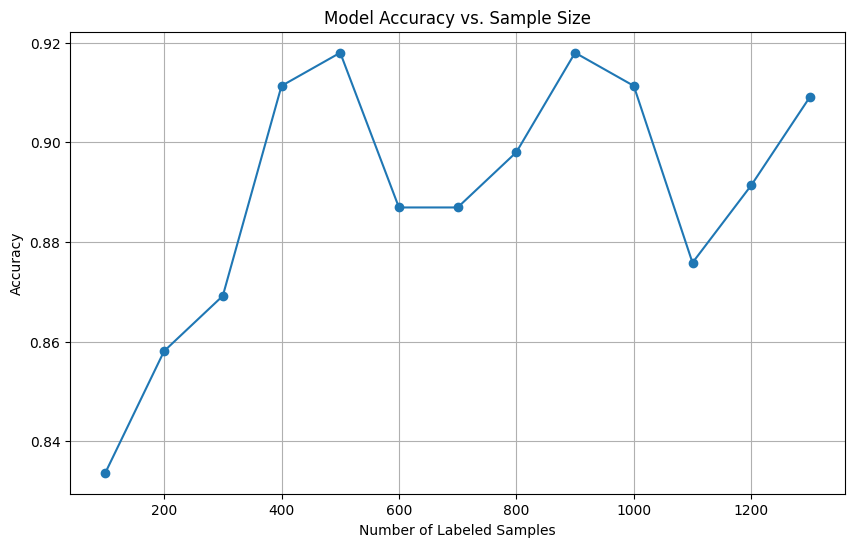

In [ ]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(num_labeled_values, accuracy_values, marker='o')
plt.title('Model Accuracy vs. Sample Size')
plt.xlabel('Number of Labeled Samples')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

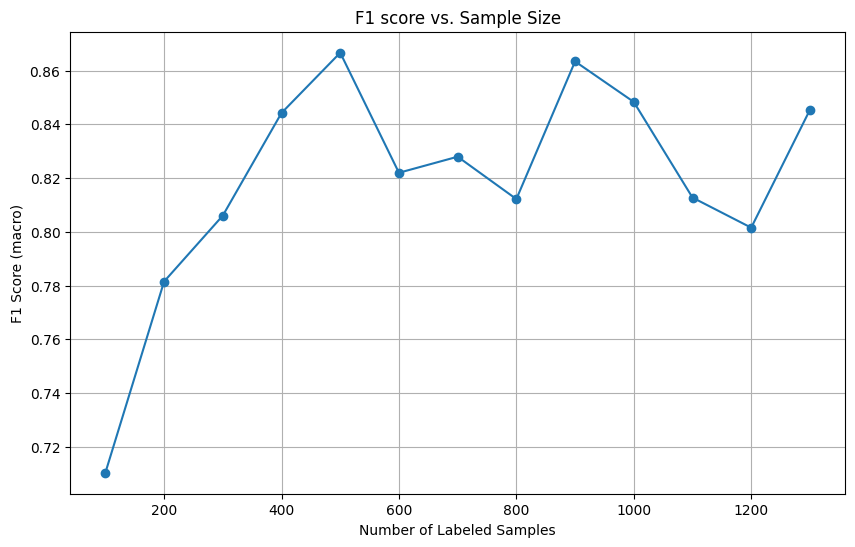

In [ ]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(num_labeled_values, f1_score_macro_values, marker='o')
plt.title('F1 score vs. Sample Size')
plt.xlabel('Number of Labeled Samples')
plt.ylabel("F1 Score (macro)")
plt.grid(True)
plt.show()

In [ ]:
# Create a DataFrame from the results
results_df = pd.DataFrame({
    'Sample_Size': num_labeled_values,
    'SGAN_Accuracy': accuracy_values,
    'SGAN_F1_Score_Macro': f1_score_macro_values
})

# Display the DataFrame
results_df

,Sample_Size,SGAN_Accuracy,SGAN_F1_Score_Macro
0,100,0.833703,0.710306
1,200,0.858093,0.781487
2,300,0.869180,0.806033
3,400,0.911308,0.844239
4,500,0.917960,0.866668
5,600,0.886918,0.821973
6,700,0.886918,0.827959
7,800,0.898004,0.812181
8,900,0.917960,0.863425
9,1000,0.911308,0.848342


In [ ]:
results_df.to_csv('/content/gdrive/My Drive/SGAN/sgan.csv',index=False)